# Libraries

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from datetime import datetime, date
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from sklearn.metrics import r2_score

# Input data - dropping date and bitcoin opening, high and low prices

In [14]:
data = pd.read_csv('/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/datasets/jrfm-2156907-cleaned.csv')

In [15]:
data['Date'] = pd.to_datetime(data['Date'])

In [16]:
data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,Active Addr Cnt,Xfer Cnt,Mean Tx Size (native units),Total Fees (USD),...,RUB,Tweets,Google,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,2015-08-07,278.740997,280.391998,276.365997,279.584991,42484800.0,283150,497302,2.057514,7235.134845,...,64.480003,47467,90.000000,0,0,0,0,1,0,0
1,2015-08-08,279.742004,279.928009,260.709991,260.997009,58533000.0,266587,284532,3.675623,5806.842316,...,64.480003,29031,91.578947,0,0,0,0,0,1,0
2,2015-08-09,261.115997,267.002991,260.467987,265.083008,23789600.0,262571,276720,4.201519,4952.554125,...,64.480003,27132,91.578947,0,0,0,0,0,0,1
3,2015-08-10,265.477997,267.032013,262.596008,264.470001,20979400.0,292834,304538,3.463212,7563.840456,...,64.480003,27744,96.315789,1,0,0,0,0,0,0
4,2015-08-11,264.342010,270.385986,264.093994,270.385986,25433900.0,271613,280398,3.785274,7128.842169,...,62.889999,26653,104.210526,0,1,0,0,0,0,0


In [17]:
data.shape

(2430, 48)

In [18]:
data.isna().sum()

Date                           0
BTC_Open                       0
BTC_High                       0
BTC_Low                        0
BTC_Close                      0
BTC_Volume                     0
Active Addr Cnt                0
Xfer Cnt                       0
Mean Tx Size (native units)    0
Total Fees (USD)               0
Mean Hash Rate                 0
Difficulty                     0
Mean Block Size (in bytes)     0
Sum Block Weight               0
LTC                            0
XRP                            0
DASH                           0
DOGE                           0
ETH                            0
Gold                           0
Silver                         0
Copper                         0
Oil                            0
Treasury Yield 10 Years        0
S&P500                         0
DJI                            0
CBOE                           0
NASDAQ                         0
JP225                          0
CSI300                         0
DXY       

# Split data into train and test set

In [19]:
start_day_p2 = pd.Timestamp(2018, 10, 1)
test_day_p2 = pd.Timestamp(2021, 10, 1)
end_day_p2 = pd.Timestamp(2022, 4, 1)

period2 = data[(data["Date"] >= start_day_p2) & (data["Date"] <= end_day_p2) ].reset_index(drop = True)
train_dataset_p2 = period2[period2["Date"] < test_day_p2].reset_index(drop = True)
test_dataset_p2 = period2[period2["Date"] >= test_day_p2].reset_index(drop = True)
train_dataset_p2 = train_dataset_p2.drop(columns = ["Date"])
test_dataset_p2 = test_dataset_p2.drop(columns = ["Date"])

In [20]:
# Define the target variable
target = 'BTC_Close'

# Create the feature sets
X_train = train_dataset_p2
X_test = test_dataset_p2

# Create the target sets
Y_train = train_dataset_p2[target]
Y_test = test_dataset_p2[target]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

ts = 3 # Define the time step
# Create sequences with a time step defined by ts
def create_sequences(data, target, time_step=ts):
	X, y = [], []
	for i in range(len(data) - time_step):
		X.append(data[i:(i + time_step)])
		y.append(target[i + time_step])
	return np.array(X), np.array(y)

X_train, Y_train = create_sequences(X_train.values, Y_train.values)
X_test, Y_test = create_sequences(X_test.values, Y_test.values)

print("X_train shape after sequencing:", X_train.shape)
print("X_test shape after sequencing:", X_test.shape)
print("Y_train shape after sequencing:", Y_train.shape)
print("Y_test shape after sequencing:", Y_test.shape)

X_train shape: (1096, 47)
X_test shape: (183, 47)
Y_train shape: (1096,)
Y_test shape: (183,)
X_train shape after sequencing: (1093, 3, 47)
X_test shape after sequencing: (180, 3, 47)
Y_train shape after sequencing: (1093,)
Y_test shape after sequencing: (180,)


# Normalize data with MinMaxScaler

In [21]:
# Normalize the datasets using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Update the variables used for training
X_train = X_train_scaled
X_test = X_test_scaled


# Model initialization & compilation

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import root_mean_squared_error

best_rmse = 100000
best_model = None
for i in range(1, 5):
	model = tf.keras.Sequential([
		tf.keras.layers.InputLayer(shape=(X_train.shape[1], X_train.shape[2])),
		tf.keras.layers.LSTM(16, activation='relu', return_sequences=False),
		tf.keras.layers.Dropout(0.2),
		tf.keras.layers.Dense(1, activation=tf.keras.layers.LeakyReLU(alpha=0.01))
	])

	# Compile the model
	model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae', 'mse'])


	# Fit the model
	# Define early stopping callback
	early_stopping = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)

	# Fit the model with early stopping
	history = model.fit(X_train, Y_train, epochs=1000, callbacks=[early_stopping], verbose=0)
	predictions = model.predict(X_test)
	rmse = root_mean_squared_error(Y_test, predictions)
	if rmse and rmse < best_rmse:
		best_rmse = rmse
		best_model = model
	print("Best RMSE:", best_rmse)


/home/hoangbaoan1901/Development/anaconda3/envs/tf-env/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Best RMSE: 4481.16756846257


/home/hoangbaoan1901/Development/anaconda3/envs/tf-env/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Best RMSE: 4481.16756846257


/home/hoangbaoan1901/Development/anaconda3/envs/tf-env/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Best RMSE: 4481.16756846257


/home/hoangbaoan1901/Development/anaconda3/envs/tf-env/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Best RMSE: 4481.16756846257


# Fit train set with label using LSTM model, predict & visualization

In [23]:
# Use the model to make predictions on the test set
predictions = best_model.predict(X_test)

# Inverse the scaling
# predictions = scaler_Y.inverse_transform(predictions.reshape(-1, 1))
# Y_test = scaler_Y.inverse_transform(Y_test.reshape(-1, 1))

# Calculate the R^2 score
r2 = r2_score(Y_test, predictions)
print("R^2 score:", r2)
# RMSE

rmse = root_mean_squared_error(Y_test, predictions)
print("RMSE:", rmse)

# Directional Accuracy
def directional_accuracy(y_true, y_pred):
	y_test_da = np.array(y_true)
	y_pred_0 = y_pred[1:] - y_test_da[:-1]
	y_test_0 = y_true[1:] - y_test_da[:-1]
	DA = (y_pred_0<0) == (y_test_0<0)
	return np.mean(DA)*100

da = directional_accuracy(Y_test, predictions)



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
R^2 score: 0.7428504178859507
RMSE: 4481.16756846257


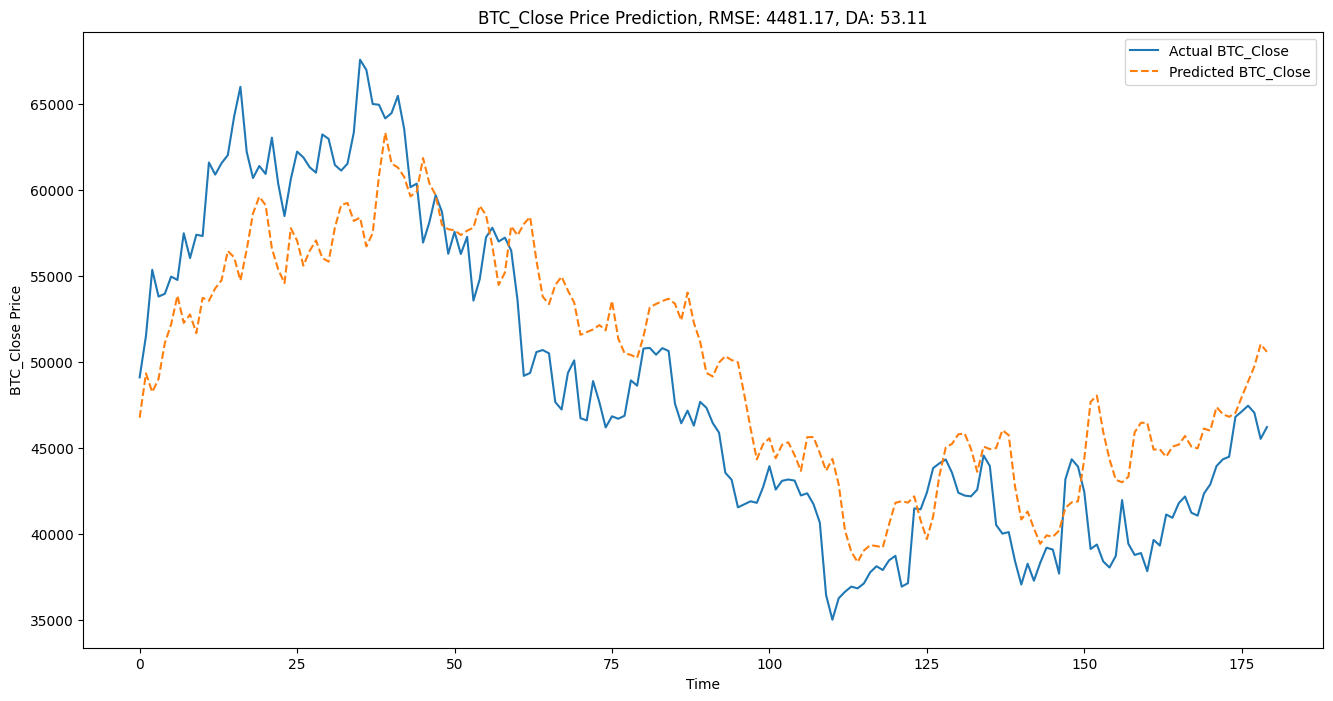

In [24]:
# Plot the predictions against the actual values
plt.figure(figsize=(16, 8))
plt.plot(Y_test, label='Actual BTC_Close')
plt.plot(predictions, label='Predicted BTC_Close', linestyle='dashed')
plt.title('BTC_Close Price Prediction, RMSE: {:.2f}, DA: {:.2f}'.format(rmse, da))
plt.xlabel('Time')
plt.ylabel('BTC_Close Price')
plt.legend()
plt.show()